In [1]:
suppressPackageStartupMessages({
    ## This is my custom library for various helper functions for spatial pre-processing 
    # devtools::install_github('korsunskylab/spatula', dependencies = FALSE)    
    # devtools::install_github('korsunskylab/spatula')
    library(harmony)
    library(uwot)
    library(singlecellmethods)
    library(sfarrow)
    library(geojsonsf)
    library(sf)    
    library(lme4)
    library(furrr)
    library(future)
    library(arm)
    library(spatula)
    library(purrr)
    library(furrr)
    library(circlize)
    library(ComplexHeatmap)
    library(ggrepel)
    library(future)
    library(scales)
    library(glue)
    library(data.table)
    library(spatstat)
    library(tidyr)
    library(dplyr)
    library(data.table)
    library(presto)
    library(ggplot2)
    library(ggthemes)
    library(patchwork)
    library(Matrix)
})

fig.size <- function(h, w) {
    options(repr.plot.height = h, repr.plot.width = w)
}

source('utils_plotting.R')
source('utils.R')



# Data

In [2]:
meta_data <- fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/meta_data.csv') %>% 
    subset(!is.na(type_lvl2) & type_lvl2 != '') %>% 
    subset(!is.na(type_lvl1) & type_lvl1 != '') %>% 
    dplyr::mutate(hubType = case_when(
        hubType == 'immune_other' ~ 'tumor', 
        TRUE ~ hubType
    ))

meta_data$cell <- as.character(meta_data$cell)


In [3]:
head(meta_data)

cell,library,X,Y,ntx,ngene,nblank,hubID,hubSize_tiles,hubSize_um2,hubType,type_lvl1,type_lvl2
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>
1,Patient001,7086.414,79.414864,30,23,0,R686,66,165000,tumor,Epithelial,Epithelial
2,Patient001,7090.282,-74.397942,16,14,0,R490,233,542538,tumor,Lymphocyte,B
3,Patient001,7087.515,-21.805606,15,12,1,R490,233,542538,tumor,Epithelial,Epithelial
4,Patient001,7099.331,-17.703966,29,20,0,R490,233,542538,tumor,Epithelial,Epithelial
5,Patient001,7100.477,-9.060024,29,16,1,R490,233,542538,tumor,Epithelial,Epithelial
6,Patient001,7093.215,-5.783358,31,22,0,R490,233,542538,tumor,Epithelial,Epithelial


# proportions (plots)

## lvl1

## lvl2

In [5]:
df = data.table(meta_data)[
    # type_lvl1 %in% c('Lymphocyte', 'Mast', 'Plasma', 'Myeloid')
][
    # , type_lvl2 := case_when(
    #     grepl('CXCL13', type_lvl2) ~ 'CXCL13 T', 
    #     TRUE ~ type_lvl2
    # )
][
    , .N, by = .(hubID, hubSize_tiles, hubSize_um2, library, hubType, type_lvl2)
] %>% 
    dplyr::mutate(density = N / hubSize_tiles) %>% # number of cells per tile 
    tidyr::spread(type_lvl2, density, fill = 0) %>% 
    tidyr::gather(type_lvl2, density, all_of(na.omit(unique(meta_data$type_lvl2))))

head(df)


,hubID,hubSize_tiles,hubSize_um2,library,hubType,N,type_lvl2,density
,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<dbl>
1,R686,66,165000,Patient001,tumor,1359,Epithelial,20.590909
2,R490,233,542538,Patient001,tumor,17,Epithelial,0.000000
3,R490,233,542538,Patient001,tumor,1769,Epithelial,7.592275
4,R686,66,165000,Patient001,tumor,32,Epithelial,0.000000
5,R490,233,542538,Patient001,tumor,406,Epithelial,0.000000
6,R686,66,165000,Patient001,tumor,14,Epithelial,0.000000


In [6]:
fig.size(8, 12)
# df_mean = data.table(df)[][
#     , 
#     .(mu = mean(density)), 
#     by = .(hubType, type_lvl2, library)
    
# ][
#     # , 
#     # .(mu = mean(mu), sig = sd(mu)), 
#     # by = .(hubType, subtype)
# ]

## Mean density over each hub 
## Then mean over means 
df_mean = data.table(df)[][
    ## mean density for each hub 
    , .(mu = mean(density)), 
    by = .(hubType, library, type_lvl2, hubID)
][
    ## average over hubs inside library:hubType
    , 
    .(mu = mean(mu), sigma = sd(mu)), 
    by = .(hubType, type_lvl2, library)
    
]

df_mean$hubType <- factor(df_mean$hubType, c('tumor', 'vascular', 'immune_hub', 'hybrid_hub'))

head(df_mean)



hubType,type_lvl2,library,mu,sigma
<fct>,<chr>,<chr>,<dbl>,<dbl>
tumor,Epithelial,Patient001,1.9014862,2.24309367
vascular,Epithelial,Patient001,0.9267456,1.18192358
immune_hub,Epithelial,Patient001,1.3268288,0.84515053
hybrid_hub,Epithelial,Patient001,0.1165828,0.07617829
tumor,Epithelial,Patient002,3.0450385,2.67147042
vascular,Epithelial,Patient002,1.7554859,1.49254502


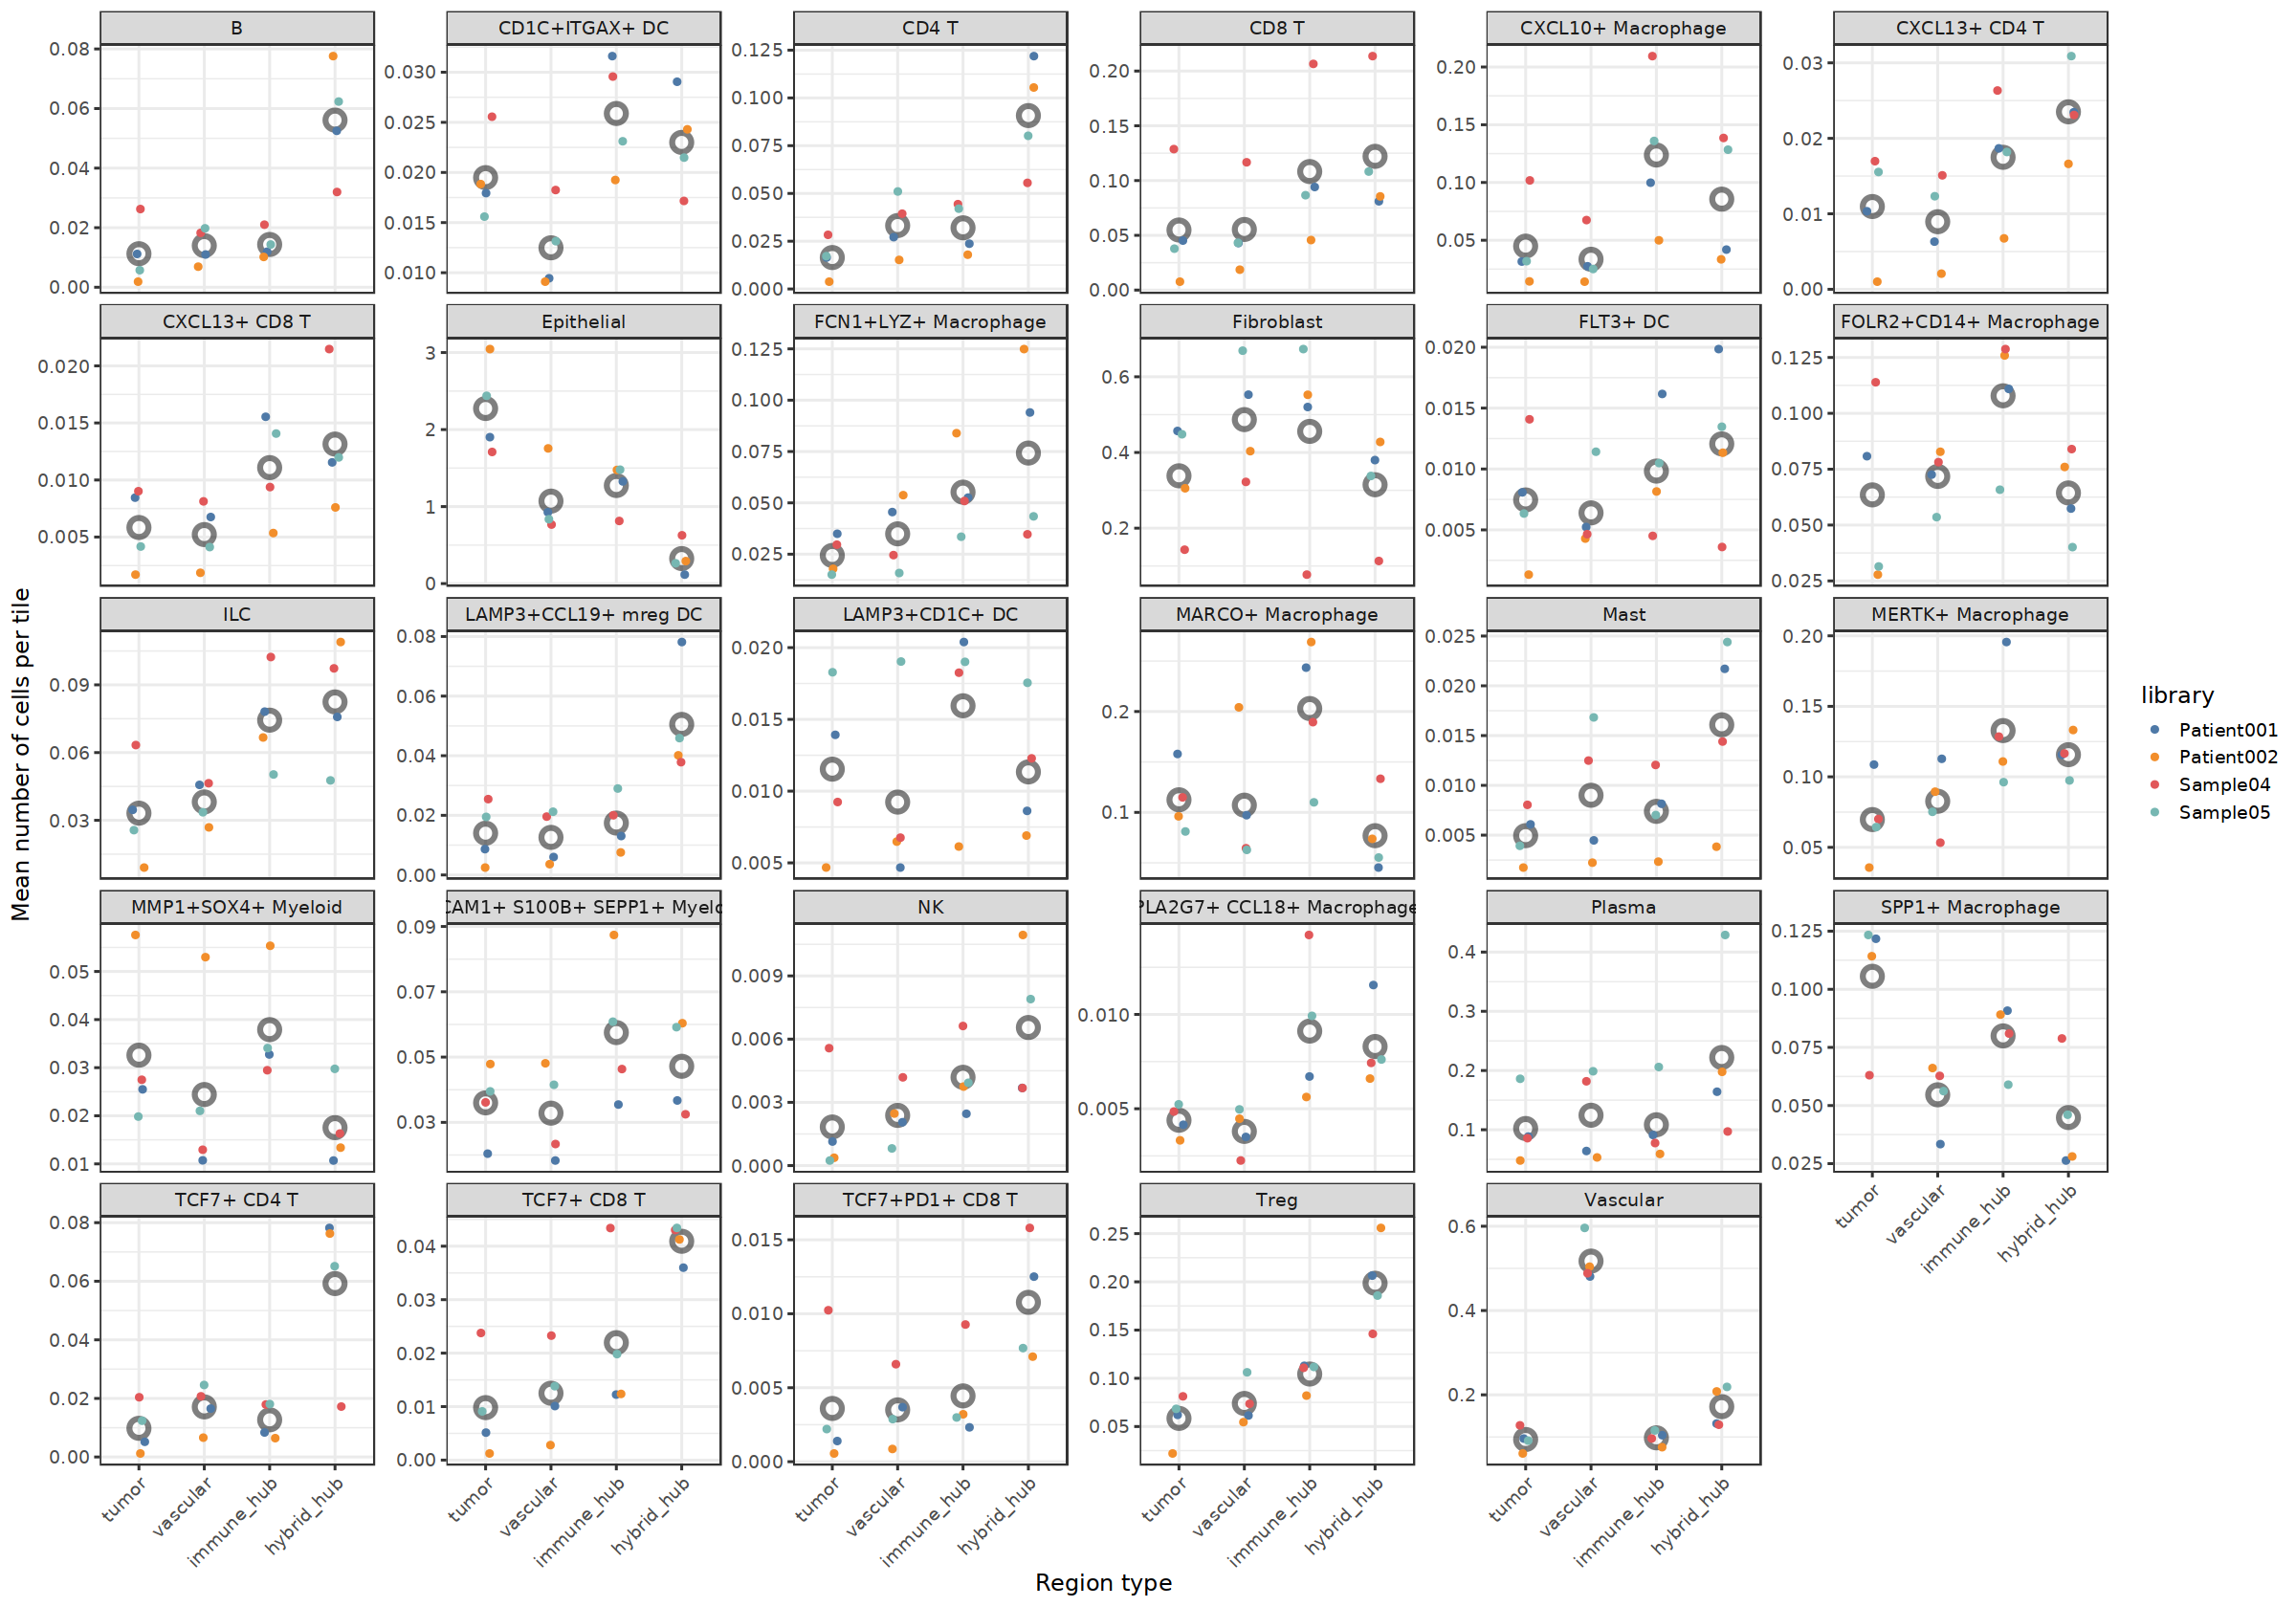

In [7]:
fig.size(14, 20)
df_mean %>% 
ggplot(aes(hubType, mu, color = library)) + 
    geom_point(
        data = df_mean[, .(mu = mean(mu)), by = .(hubType, type_lvl2)], 
        color = 'black', size = 4, shape = 21, alpha = .5, stroke = 2
    ) + 
    geom_point(position = position_jitter(width = .1, height = 0)) + 
    # geom_line(aes(group = library), alpha = .3) + 
    facet_wrap(~type_lvl2, scales = 'free_y') + 
    theme_bw(base_size = 14) + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    labs(x = 'Region type', y = 'Mean number of cells per tile') + 
    scale_color_tableau() + 
    NULL


# Proportions (lmer)

glmer above did not make sense with the plots. The code below now does. 


## TESTING

In [8]:
df = data.table(meta_data)[
    # type_lvl1 %in% c('Lymphocyte', 'Mast', 'Plasma', 'Myeloid')
][
    # , type_lvl2 := case_when(
    #     grepl('CXCL13', type_lvl2) ~ 'CXCL13 T', 
    #     TRUE ~ type_lvl2
    # )
][
    , .N, by = .(hubID, hubSize_tiles, hubSize_um2, library, hubType, type_lvl2)
] %>% 
    dplyr::mutate(density = N / hubSize_tiles) %>% # number of cells per tile 
    tidyr::spread(type_lvl2, density, fill = 0) %>% 
    tidyr::gather(type_lvl2, density, all_of(na.omit(unique(meta_data$type_lvl2))))

head(df)


,hubID,hubSize_tiles,hubSize_um2,library,hubType,N,type_lvl2,density
,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<dbl>
1,R686,66,165000,Patient001,tumor,1359,Epithelial,20.590909
2,R490,233,542538,Patient001,tumor,17,Epithelial,0.000000
3,R490,233,542538,Patient001,tumor,1769,Epithelial,7.592275
4,R686,66,165000,Patient001,tumor,32,Epithelial,0.000000
5,R490,233,542538,Patient001,tumor,406,Epithelial,0.000000
6,R686,66,165000,Patient001,tumor,14,Epithelial,0.000000


In [9]:
# df_mean[hubType %in% c('hybrid_hub', 'tumor') & grepl('CXCL10', type_lvl2)][, .(mu, library, hubType)] %>% 
#     tidyr::spread(hubType, mu) %>% 
#     dplyr::mutate(hybrid_hub / tumor) %>% 
#     with(mean(`hybrid_hub/tumor`))

df_mean[hubType %in% c('immune_hub', 'tumor') & grepl('CXCL10', type_lvl2)][, .(mu, library, hubType)] %>% 
    tidyr::spread(hubType, mu) %>% 
    dplyr::mutate(immune_hub / tumor) %>% 
    with(mean(`immune_hub/tumor`))


[1] 3.242409

In [10]:
# df = meta_data %>% 
#     subset(!is.na(type_lvl2)) %>% 
#     dplyr::mutate(hubType = case_when(
#         hubType == 'immune_other' ~ 'tumor', 
#         TRUE ~ hubType
#     ))

# df = data.table(df)[!is.na(type_lvl2), .N, by = .(hubID, hubSize_tiles, hubSize_um2, library, hubType, type_lvl2)] %>% 
#     dplyr::mutate(density = N / hubSize_tiles) %>% # number of cells per tile 
#     tidyr::spread(type_lvl2, density, fill = 0) %>% 
#     tidyr::gather(type_lvl2, density, all_of(na.omit(unique(meta_data$type_lvl2))))

df_hub = data.table(df)[][
    , .(mu = mean(density)), 
    by = .(hubType, library, type_lvl2, hubID, hubSize_tiles)
]
head(df_hub)

hubType,library,type_lvl2,hubID,hubSize_tiles,mu
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
tumor,Patient001,Epithelial,R686,66,1.4707792
tumor,Patient001,Epithelial,R490,233,0.3036910
vascular,Patient001,Epithelial,R850,296,0.3521959
tumor,Patient001,Epithelial,R642,3676,1.0929104
tumor,Patient001,Epithelial,R521,67,0.2736318
vascular,Patient001,Epithelial,R859,13,0.4538462


### vs-tumor

In [11]:
# type = 'immune_hub'
type = 'hybrid_hub'

data_df = df_hub[][
    hubType %in% c('tumor', type)
][
    , hubType := factor(hubType, c('tumor', type))
][
    !is.na(hubType)
][type_lvl2 == 'CXCL10+ Macrophage']


data_df = left_join(data_df, unique(meta_data[, .(hubID, hubSize_tiles)]))

Joining with `by = join_by(hubID, hubSize_tiles)`


In [12]:
# fig.size(8, 10)
# data_df[order(hubSize_tiles)][grepl('CXCL10', type_lvl2) & grepl('hybrid', hubType)] %>% 
#     ggplot(aes(mu, hubSize_tiles)) + 
#         geom_point() + 
#         scale_y_log10() +
#         facet_wrap(~library, scales = 'free') + 
#         NULL


In [13]:
# h0 = lmer(mu ~ 1 + (1|library), data_df, REML = FALSE, weights = data_df$hubSize_tiles)
# h1 = lmer(mu ~ 1 + hubType + (1|library), data_df, REML = FALSE) 
# h1 = lmer(mu ~ 1 + hubType + (1|library), data_df, REML = FALSE, weights = data_df$hubSize_tiles) 
# fixef(h1)
# ranef(h1)
# anova(h0, h1)


# h0 = lmer(mu ~ 1 + (1|library/hubType), data_df, REML = FALSE) 
# h1 = lmer(mu ~ 1 + hubType + (1|library/hubType), data_df, REML = FALSE) 
# h0 = lmer(mu ~ 1 + (1|library/hubType), data_df, REML = FALSE, weights = data_df$hubSize_tiles)
# h1 = lmer(mu ~ 1 + hubType + (1|library/hubType), data_df, REML = FALSE, weights = data_df$hubSize_tiles) 
h0 = lmer(mu ~ 1 + (1|library/hubType), data_df, REML = FALSE, weights = log(data_df$hubSize_tiles))
h1 = lmer(mu ~ 1 + hubType + (1|library/hubType), data_df, REML = FALSE, weights = log(data_df$hubSize_tiles))
# fixef(h1)
# ranef(h1)
log2(sum(fixef(h1)) / fixef(h1)[['(Intercept)']])
anova(h0, h1)





[1] 1.045359

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
h0,4,-1846.697,-1828.029,927.3485,-1854.697,NA,NA,NA
h1,5,-1851.739,-1828.405,930.8697,-1861.739,7.042309,1,0.007960633


In [14]:
## Sanity check: mean of means should be equal to odds ratio (SD can be different)



In [15]:
res_vs_tumor = map(c('immune_hub', 'hybrid_hub', 'vascular'), function(type) {
    foo <- function(data_df) {
        suppressMessages({
            # h0 = lmer(mu ~ 1 + (1|library/hubType), data_df, REML = FALSE) #, weights = data_df$hubSize_tiles)
            # h1 = lmer(mu ~ 1 + hubType + (1|library/hubType), data_df, REML = FALSE) #, weights = data_df$hubSize_tiles) 
            h0 = lmer(mu ~ 1 + (1|library/hubType), data_df, REML = FALSE, weights = log(data_df$hubSize_tiles))
            h1 = lmer(mu ~ 1 + hubType + (1|library/hubType), data_df, REML = FALSE, weights = log(data_df$hubSize_tiles))
            # h0 = lmer(mu ~ 1 + (1|library/hubType), data_df, REML = FALSE)
            # h1 = lmer(mu ~ 1 + hubType + (1|library/hubType), data_df, REML = FALSE)              
            # h0 = lmer(mu ~ 1 + (1|library), data_df, REML = FALSE)
            # h1 = lmer(mu ~ 1 + hubType + (1|library), data_df, REML = FALSE)              
        })
        tibble(
            pval = anova(h0, h1)['h1', 'Pr(>Chisq)'], 
            logOR = log2(sum(fixef(h1)) / fixef(h1)[['(Intercept)']]),
            zscore = sign(logOR) * sqrt(anova(h0, h1)['h1', 'Chisq'])
        )
    }

    df_hub[
    ][
        hubType %in% c('tumor', type)
    ][
        , hubType := factor(hubType, c('tumor', type))
    ][
        , foo(.SD), by = type_lvl2
    ][
        order(-logOR)
    ][
        , fdr := p.adjust(pval)
    ][
        , hubType := type
    ][
        , SD := logOR / zscore ## for plotting 
    ][]

}) %>% 
    bind_rows() %>% 
    dplyr::select(hubType, everything())


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.006309 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00355808 (tol = 0.002, component 1)”


In [16]:
res_vs_tumor[grepl('CXCL10', type_lvl2)]

hubType,type_lvl2,pval,logOR,zscore,fdr,SD
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
immune_hub,CXCL10+ Macrophage,0.003450708,1.73119560,2.9244452,0.06901416,0.5919740
hybrid_hub,CXCL10+ Macrophage,0.007960633,1.04535901,2.6537350,0.09552759,0.3939199
vascular,CXCL10+ Macrophage,0.708717501,-0.06576095,-0.3735791,1.00000000,0.1760295


In [17]:
table(res_vs_tumor$fdr < .01)


FALSE  TRUE 
   77    10 

In [18]:
res_vs_tumor[fdr < .05][order(hubType, -zscore)]

hubType,type_lvl2,pval,logOR,zscore,fdr,SD
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hybrid_hub,TCF7+ CD8 T,2.368572e-05,2.439968,4.226972,6.868858e-04,0.5772377
hybrid_hub,TCF7+PD1+ CD8 T,2.150771e-04,2.367704,3.700616,5.807082e-03,0.6398135
hybrid_hub,Treg,3.236043e-04,1.960327,3.595633,8.413711e-03,0.5451967
hybrid_hub,PLA2G7+ CCL18+ Macrophage,3.936714e-04,1.442195,3.544290,9.841784e-03,0.4069067
hybrid_hub,CXCL13+ CD4 T,8.316765e-04,1.585809,3.342031,1.996024e-02,0.4745044
hybrid_hub,CD4 T,8.336783e-04,2.727029,3.341364,1.996024e-02,0.8161423
hybrid_hub,B,8.493593e-04,2.617389,3.336187,1.996024e-02,0.7845449
hybrid_hub,CD8 T,1.249959e-03,1.219948,3.227228,2.624914e-02,0.3780173
hybrid_hub,LAMP3+CCL19+ mreg DC,2.130978e-03,2.158323,3.071344,4.261955e-02,0.7027292


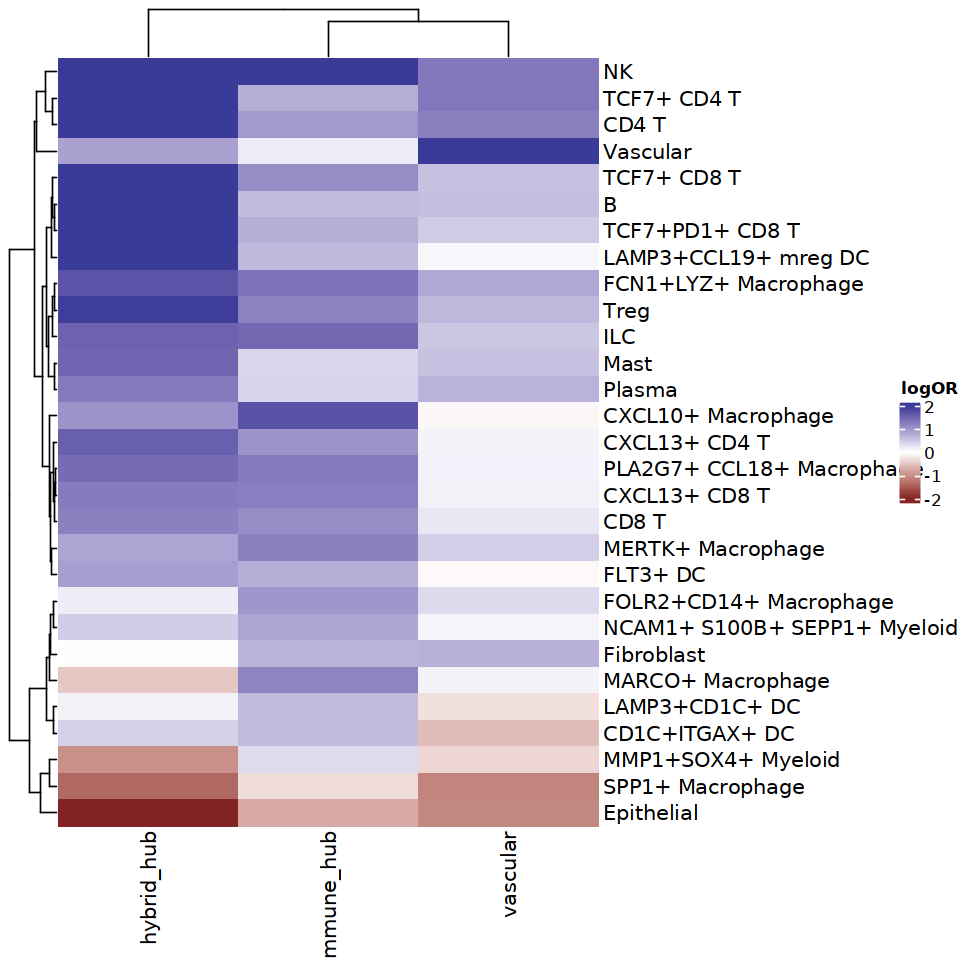

In [19]:
fig.size(8, 8)
X = res_vs_tumor[, .(hubType, type_lvl2, SCORE = logOR)] %>% 
    tidyr::spread(hubType, SCORE) %>% 
    data.frame() %>% 
    tibble::column_to_rownames('type_lvl2') %>% 
    as.matrix() %>%
    # pmin(2) %>% pmax(-2) %>% 
    identity()
Heatmap(
    X,
    name = 'logOR',
    col = colorRamp2(c(-2, 0, 2), c(muted('red'), 'white', muted('blue')))
)

In [20]:
# fig.size(12, 8)
# res_vs_tumor %>% 
#     # dplyr::mutate(sigma = pmin(SD, sigma_max)) %>% 
#     ggplot(aes(hubType, logOR, color = hubType)) + 
#         geom_point() + 
#         geom_errorbar(aes(ymin = logOR - 1.96 * SD, ymax = logOR + 1.96 * SD), width = 0) + 
#         coord_flip() + 
#         facet_grid(type_lvl2 ~ ., space = "free", scales = "free") + #, switch = grid.switch) + 
#         geom_hline(yintercept = c(0), linetype = 2) + 
#         labs(x = "", y = "Log2 odds ratio", title = 'Cell type abundance (vs tumor)') + 
#         geom_hline(yintercept = c(0), linetype = 2) + 
#         theme(
#             axis.text.y = element_blank(), 
#             axis.ticks.y = element_blank(), legend.position = "bottom", 
#             strip.text.y = element_text(angle = 0, hjust = 0),
#             # panel.background = element_blank()
#             panel.background = element_rect(linewidth = .1)
#         ) + 
#         scale_y_continuous(breaks = -10:10) + 
#         scale_color_tableau() + 
#         NULL


### hybrid vs immunity

In [21]:
foo <- function(data_df) {
    suppressMessages({
        h0 = lmer(mu ~ 1 + (1|library/hubType), data_df, REML = FALSE, weights = log(data_df$hubSize_tiles))
        h1 = lmer(mu ~ 1 + hubType + (1|library/hubType), data_df, REML = FALSE, weights = log(data_df$hubSize_tiles))
        # h0 = lmer(mu ~ 1 + (1|library/hubType), data_df, REML = FALSE)
        # h1 = lmer(mu ~ 1 + hubType + (1|library/hubType), data_df, REML = FALSE)  
    })
    tibble(
        pval = anova(h0, h1)['h1', 'Pr(>Chisq)'], 
        logOR = log2(sum(fixef(h1)) / fixef(h1)[['(Intercept)']]),
        zscore = sign(logOR) * sqrt(anova(h0, h1)['h1', 'Chisq'])
    )
}
bar <- function(lvl_bg, lvl_fg) {
    df_hub[
    ][
        hubType %in% c(lvl_bg, lvl_fg)
    ][
        , hubType := factor(hubType, c(lvl_bg, lvl_fg))
    ][
        , foo(.SD), by = type_lvl2
    ][
        order(-logOR)
    ][
        , fdr := p.adjust(pval)
    ][
        , SD := logOR / zscore ## for plotting 
    ][]
    
}

# res_hubs = df_hub[
# ][
#     hubType %in% c('immune_hub', 'hybrid_hub')
# ][
#     , hubType := factor(hubType, c('immune_hub', 'hybrid_hub'))
# ][
#     , foo(.SD), by = type_lvl2
# ][
#     order(-logOR)
# ][
#     , fdr := p.adjust(pval)
# ][
#     , SD := logOR / zscore ## for plotting 
# ][]


type_lvl2,pval,logOR,zscore,fdr,SD
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCF7+ CD4 T,0.0039970596,2.4544156,2.878394,0.088447461,0.8527032
B,0.0016584944,1.9300501,3.145418,0.043120856,0.6136068
CD4 T,0.0038455418,1.6512450,2.890562,0.088447461,0.5712541
TCF7+PD1+ CD8 T,0.0008523091,1.6179989,3.335223,0.023864654,0.4851246
FOLR2+CD14+ Macrophage,0.0012845784,-0.8524724,-3.219403,0.034683616,0.2647921
SPP1+ Macrophage,0.0032829727,-1.0475318,-2.939920,0.078791344,0.3563130
MARCO+ Macrophage,0.0022857584,-1.6934333,-3.050349,0.057143959,0.5551606
Epithelial,0.0001837571,-2.1189000,-3.740360,0.005328955,0.5664963


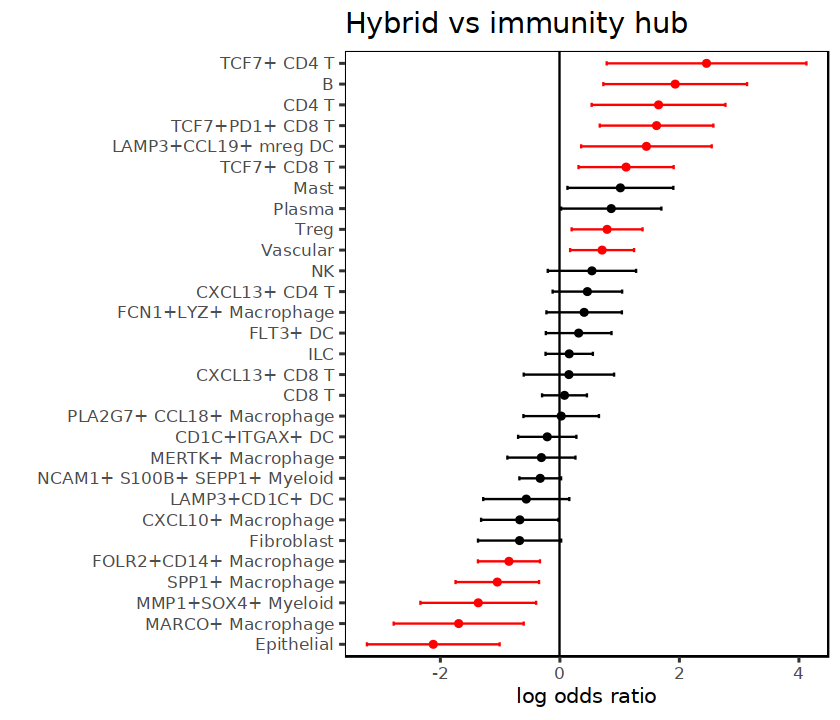

In [22]:
hybrid_vs_immunity = bar('immune_hub', 'hybrid_hub')
hybrid_vs_immunity[fdr < .1]

fig.size(6, 7)
p1 = hybrid_vs_immunity %>% 
    ggplot(aes(reorder(type_lvl2, logOR), logOR, color = fdr < .2)) + 
        geom_point() + 
        geom_errorbar(aes(ymin = logOR - 1.96 * SD, ymax = logOR + 1.96 * SD), width = .2) + 
        coord_flip() + 
        geom_hline(yintercept = 0) + 
        scale_color_manual(values = c('black', 'red')) +
        labs(title = 'Hybrid vs immunity hub', y = 'log odds ratio', x = '') + 
        guides(color = 'none') + 
        NULL
p1

type_lvl2,pval,logOR,zscore,fdr,SD
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCF7+ CD4 T,2.153746e-03,3.2771951,3.068169,0.0426195548,1.0681272
CD4 T,8.336783e-04,2.7270287,3.341364,0.0199602365,0.8161423
B,8.493593e-04,2.6173885,3.336187,0.0199602365,0.7845449
TCF7+ CD8 T,2.368572e-05,2.4399677,4.226972,0.0006868858,0.5772377
NK,6.246209e-03,2.3909698,2.734569,0.0812007227,0.8743499
TCF7+PD1+ CD8 T,2.150771e-04,2.3677037,3.700616,0.0058070816,0.6398135
LAMP3+CCL19+ mreg DC,2.130978e-03,2.1583227,3.071344,0.0426195548,0.7027292
Treg,3.236043e-04,1.9603270,3.595633,0.0084137109,0.5451967
CXCL13+ CD4 T,8.316765e-04,1.5858087,3.342031,0.0199602365,0.4745044


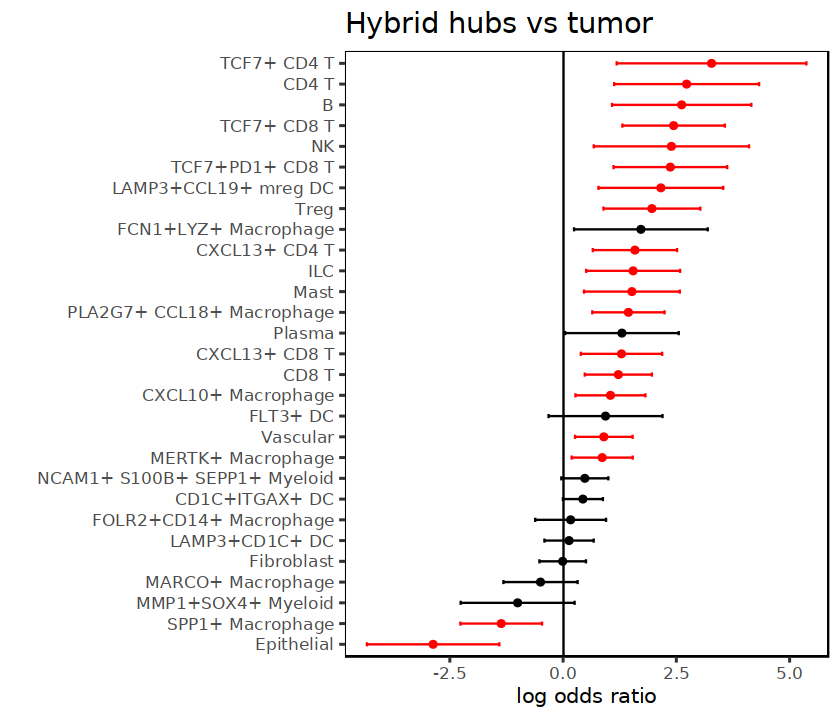

In [23]:
hybrid_vs_tumor = bar('tumor', 'hybrid_hub')
hybrid_vs_tumor[fdr < .1]

fig.size(6, 7)
p2 = hybrid_vs_tumor %>% 
    ggplot(aes(reorder(type_lvl2, logOR), logOR, color = fdr < .2)) + 
        geom_point() + 
        geom_errorbar(aes(ymin = logOR - 1.96 * SD, ymax = logOR + 1.96 * SD), width = .2) + 
        coord_flip() + 
        geom_hline(yintercept = 0) + 
        scale_color_manual(values = c('black', 'red')) +
        labs(title = 'Hybrid hubs vs tumor', y = 'log odds ratio', x = '') + 
        guides(color = 'none') + 
        NULL
p2

type_lvl2,pval,logOR,zscore,fdr,SD
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NK,1.904529e-03,2.0599967,3.104730,0.043804177,0.6635027
CXCL10+ Macrophage,3.450708e-03,1.7311956,2.924445,0.069014162,0.5919740
ILC,2.293590e-04,1.4730892,3.684270,0.006422052,0.3998320
FCN1+LYZ+ Macrophage,3.957704e-03,1.3712093,2.881513,0.075196370,0.4758643
PLA2G7+ CCL18+ Macrophage,1.071126e-03,1.2811730,3.271146,0.027849279,0.3916588
MERTK+ Macrophage,1.150458e-03,1.2219511,3.250887,0.028761440,0.3758824
Treg,6.392684e-05,1.2170649,3.997826,0.001853878,0.3044317
CD8 T,9.926768e-04,1.1078891,3.292594,0.026802275,0.3364791
TCF7+ CD8 T,2.451092e-03,1.0997868,3.029315,0.053924030,0.3630481


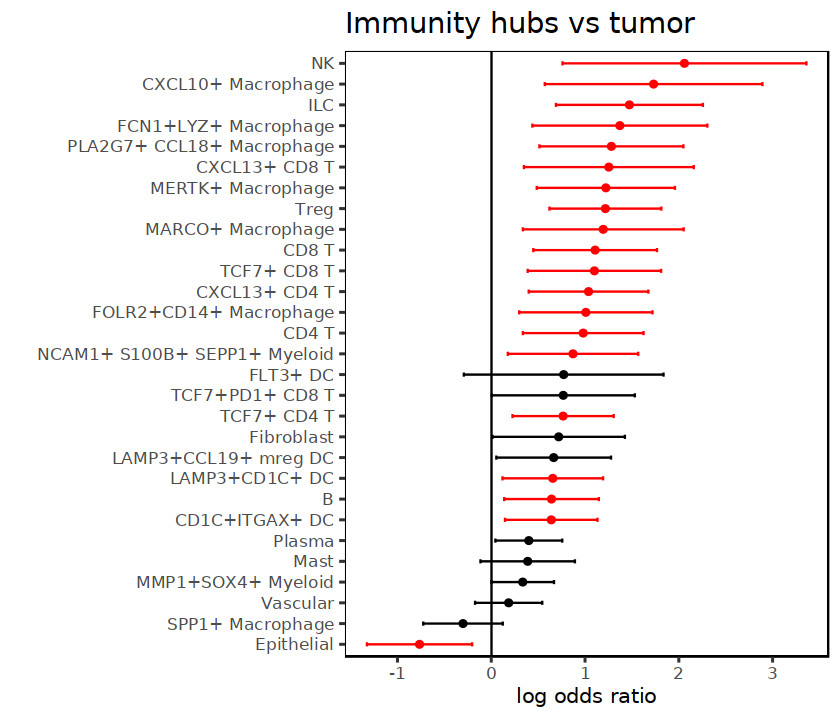

In [24]:
immune_vs_tumor = bar('tumor', 'immune_hub')
immune_vs_tumor[fdr < .1]

fig.size(6, 7)
p3 = immune_vs_tumor %>% 
    ggplot(aes(reorder(type_lvl2, logOR), logOR, color = fdr < .2)) + 
        geom_point() + 
        geom_errorbar(aes(ymin = logOR - 1.96 * SD, ymax = logOR + 1.96 * SD), width = .2) + 
        coord_flip() + 
        geom_hline(yintercept = 0) + 
        scale_color_manual(values = c('black', 'red')) +
        labs(title = 'Immunity hubs vs tumor', y = 'log odds ratio', x = '') + 
        guides(color = 'none') + 
        NULL
p3

In [25]:
# fig.size(6, 20)
# (p1 | p2 | p3) + plot_annotation(tag_levels = 'a')

# Cache

In [26]:
head(res_vs_tumor[hubType == 'immune_hub'])

hubType,type_lvl2,pval,logOR,zscore,fdr,SD
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
immune_hub,NK,0.001904529,2.059997,3.104730,0.043804177,0.6635027
immune_hub,CXCL10+ Macrophage,0.003450708,1.731196,2.924445,0.069014162,0.5919740
immune_hub,ILC,0.000229359,1.473089,3.684270,0.006422052,0.3998320
immune_hub,FCN1+LYZ+ Macrophage,0.003957704,1.371209,2.881513,0.075196370,0.4758643
immune_hub,PLA2G7+ CCL18+ Macrophage,0.001071126,1.281173,3.271146,0.027849279,0.3916588
immune_hub,CXCL13+ CD8 T,0.006667542,1.253770,2.713008,0.101442312,0.4621327


In [27]:
fwrite(df_hub, 'data/df_hub_props.csv')
fwrite(df_mean, 'data/df_hub_means_props.csv')

In [28]:
list(
    hybrid_vs_immunity = hybrid_vs_immunity,
    hybrid_vs_tumor = hybrid_vs_tumor,
    immune_vs_tumor = immune_vs_tumor,
    vascular_vs_tumor = res_vs_tumor[hubType == 'vascular'][, hubType := NULL]
) %>% 
    bind_rows(.id = 'comparison') %>% 
    fwrite('tables/hub_cell_enrichment_stats.csv')
    # fwrite('data/hub_cell_enrichment_stats.csv')


In [29]:
df_hub = fread('data/df_hub_props.csv')
df_mean = fread('data/df_hub_means_props.csv')
stats = fread('tables/hub_cell_enrichment_stats.csv')

In [30]:
df_mean[grepl('CXCL10', type_lvl2)][order(library, hubType)][grepl('hybrid|tumor', hubType)][, .(hubType, mu, library)] %>% 
    tidyr::spread(hubType, mu) %>% 
    dplyr::mutate(hybrid_hub / tumor)

library,hybrid_hub,tumor,hybrid_hub/tumor
<chr>,<dbl>,<dbl>,<dbl>
Patient001,0.04188203,0.03153125,1.328270
Patient002,0.03344536,0.01435433,2.329983
Sample04,0.13856262,0.10180442,1.361067
Sample05,0.12840259,0.03185741,4.030540


In [31]:
df_mean[grepl('CXCL10', type_lvl2)][order(library, hubType)][grepl('immune|tumor', hubType)][, .(hubType, mu, library)] %>% 
    tidyr::spread(hubType, mu) %>% 
    dplyr::mutate(immune_hub / tumor)

library,immune_hub,tumor,immune_hub/tumor
<chr>,<dbl>,<dbl>,<dbl>
Patient001,0.09981630,0.03153125,3.165630
Patient002,0.04993357,0.01435433,3.478640
Sample04,0.20942293,0.10180442,2.057110
Sample05,0.13597552,0.03185741,4.268254


In [32]:
stats[grepl('CXCL10', type_lvl2)]

comparison,type_lvl2,pval,logOR,zscore,fdr,SD
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hybrid_vs_immunity,CXCL10+ Macrophage,0.042441229,-0.67063054,-2.0291675,0.63661844,0.3304954
hybrid_vs_tumor,CXCL10+ Macrophage,0.007960633,1.04535901,2.6537350,0.09552759,0.3939199
immune_vs_tumor,CXCL10+ Macrophage,0.003450708,1.73119560,2.9244452,0.06901416,0.5919740
vascular_vs_tumor,CXCL10+ Macrophage,0.708717501,-0.06576095,-0.3735791,1.00000000,0.1760295


df_hub simply by: 

- up in one
- up in both 
- not sig


In [33]:
fdr_t = .2
logOR_t = .5

## Hybrid: Up vs tumor and vs immunity 
## Lots of things unique to stem-immunity 
up_in_hybrid = intersect(
    stats[comparison == 'hybrid_vs_tumor'][fdr < fdr_t & logOR > logOR_t, type_lvl2],
    stats[comparison == 'hybrid_vs_immunity'][fdr < fdr_t & logOR > logOR_t, type_lvl2]
)

## Immunity: Up vs tumor and vs immunity 
## Nothing unique to stem hub! 
up_in_immunity = intersect(
    stats[comparison == 'immune_vs_tumor'][fdr < fdr_t & logOR > logOR_t, type_lvl2],
    stats[comparison == 'hybrid_vs_immunity'][fdr < fdr_t & logOR < -logOR_t, type_lvl2]
)

## Up in both: things that are up in both and not unique to one
up_in_both = intersect(
    stats[comparison == 'hybrid_vs_tumor'][fdr < fdr_t & logOR > logOR_t, type_lvl2],
    stats[comparison == 'immune_vs_tumor'][fdr < fdr_t & logOR > logOR_t, type_lvl2]
) %>% 
    setdiff(up_in_hybrid) %>% 
    setdiff(up_in_immunity)


up_in_hybrid
up_in_immunity
up_in_both


[1] "TCF7+ CD4 T"          "CD4 T"                "B"                   
[4] "TCF7+ CD8 T"          "TCF7+PD1+ CD8 T"      "LAMP3+CCL19+ mreg DC"
[7] "Treg"                 "Vascular"

[1] "MARCO+ Macrophage"      "FOLR2+CD14+ Macrophage"

[1] "NK"                        "CXCL13+ CD4 T"            
[3] "ILC"                       "PLA2G7+ CCL18+ Macrophage"
[5] "CXCL13+ CD8 T"             "CD8 T"                    
[7] "CXCL10+ Macrophage"        "MERTK+ Macrophage"

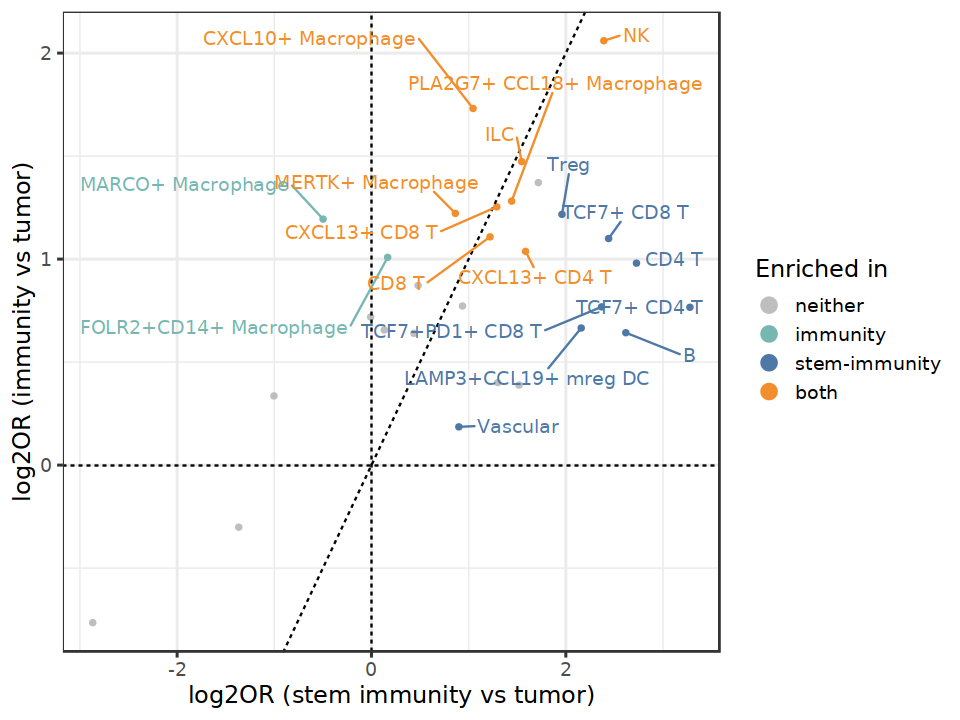

In [37]:
fig.size(6, 8)
full_join(
    stats[comparison == 'hybrid_vs_tumor'],
    # hybrid_vs_tumor,
    stats[comparison == 'immune_vs_tumor'],
    # immune_vs_tumor,
    by = c('type_lvl2'), 
    suffix = c('_hybrid', '_immunity')
) %>% 
    dplyr::mutate(LABEL = case_when(
        type_lvl2 %in% up_in_both ~ 'both', 
        type_lvl2 %in% up_in_hybrid ~ 'stem-immunity', 
        type_lvl2 %in% up_in_immunity ~ 'immunity', 
        # (fdr_immunity < fdr_t & logOR_immunity > 0) | (fdr_hybrid < fdr_t & logOR_hybrid > 0) ~ 'significant', 
        TRUE ~ 'neither'
    )) %>% 
    dplyr::mutate(LABEL = factor(LABEL, c('neither', 'immunity', 'stem-immunity', 'both'))) %>% 
    ggplot(aes(logOR_hybrid, logOR_immunity, color = LABEL)) + 
        geom_point(shape = 16) + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_vline(xintercept = 0, linetype = 2) + 
        labs(
            x = 'log2OR (stem immunity vs tumor)', 
            y = 'log2OR (immunity vs tumor)', 
            color = 'Enriched in'
        ) + 
        geom_abline(linetype = 2) + 
        # geom_errorbar(
        #     aes(ymin = logOR_immunity - 1.96 * SD_immunity, ymax = logOR_immunity + 1.96 * SD_immunity),
        #     data = . %>% subset(LABEL == 'significant'),             
        #     alpha = .3
        # ) + 
        # geom_errorbarh(
        #     aes(xmin = logOR_hybrid - 1.96 * SD_hybrid, xmax = logOR_hybrid + 1.96 * SD_hybrid),
        #     data = . %>% subset(LABEL == 'significant'), 
        #     alpha = .3
        # ) + 
        geom_text_repel(
            aes(label = type_lvl2), 
            # data = . %>% subset((fdr_immunity < fdr_t & logOR_immunity > 0) | (fdr_hybrid < fdr_t & logOR_hybrid > 0)), 
            data = . %>% subset(LABEL %in% c('both', 'stem-immunity', 'immunity')), 
            # data = . %>% subset(LABEL == 'significant'), 
            box.padding = .7, 
            # color = 'red',
            max.overlaps = Inf
        ) + 
        theme_bw(base_size = 14) + 
        # scale_color_manual(values = c('not' = 'black', 'significant' = 'red')) + 
        # scale_color_manual(values = c('neither' = 'grey', 'stem-immunity' = muted('red'), 'both' = muted('blue'))) + 
        scale_color_manual(values = c(neither = 'gray', 'stem-immunity' = '#4E79A7', 'both' = '#F28E2B', 'immunity' = '#76B7B2')) + 
        # guides(color = 'none') + 

        guides(color = guide_legend(override.aes = list(stroke = 1, alpha = 1, shape = 16, size = 4)), alpha = "none") +   
    
        ## OPTIONAL: display odds ratios, rather log odds
        # scale_x_continuous(breaks = seq(-3, 3, 1),labels = 2 ^ seq(-3, 3, 1)) + 
        # scale_y_continuous(breaks = seq(-3, 3, 1),labels = 2 ^ seq(-3, 3, 1)) + 
        # xlim(-3, 3) + ylim(-3, 3) + 
        NULL
